In [1]:
import gym
import numpy as np
import cv2
from collections import deque
import matplotlib.pyplot as plt

In [2]:
env = gym.make('SpaceInvaders-v0')

In [3]:
env.action_space

Discrete(6)

In [4]:
state = env.reset()
score = 0
while True:
    action = np.random.randint(env.action_space.n)
    next_state, reward, done, _ = env.step(action)
    score += reward
    state = next_state
    env.render()
    if done:
        print("Score", score)
        break

Score 15.0


In [5]:
env.close()

In [6]:
def preprocess_frame(frame):
    
    #scale_luminance = np.dot(frame[...,:3], [0.299, 0.587, 0.114])
    gray_image = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    normalize_image = gray_image / 255.
    resized_image = cv2.resize(normalize_image, (84, 84), interpolation = cv2.INTER_AREA)  
    
    return resized_image

def stack_frames(stacked_frames, state, is_new_episode):
    # Preprocess frame
    frame = preprocess_frame(state)
    stack_size = 4
    if is_new_episode:
        # Clear our stacked_frames
        stacked_frames = deque([np.zeros((84,84), dtype=np.int) for i in range(stack_size)], maxlen=4)
        
        # Because we're in a new episode, copy the same frame 4x
        stacked_frames.append(frame)
        stacked_frames.append(frame)
        stacked_frames.append(frame)
        stacked_frames.append(frame)
        
        # Stack the frames
        stacked_state = np.stack(stacked_frames, axis=2).transpose(2, 0, 1)
        
        
    else:
        # Append frame to deque, automatically removes the oldest frame
        stacked_frames.append(frame)
        # Build the stacked state (first dimension specifies different frames)
        stacked_state = np.stack(stacked_frames, axis=2).transpose(2, 0, 1)
        
    return stacked_state, stacked_frames


In [7]:
stacked_frames = deque([np.zeros((84,84), dtype=np.int) for i in range(4)], maxlen=4)

In [8]:
state = env.reset()

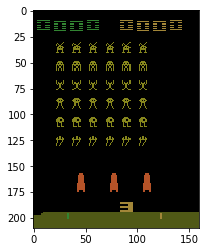

In [9]:
plt.imshow(state);

In [10]:
states, frames = stack_frames(stacked_frames, state, True)

In [11]:
states.shape

(4, 84, 84)

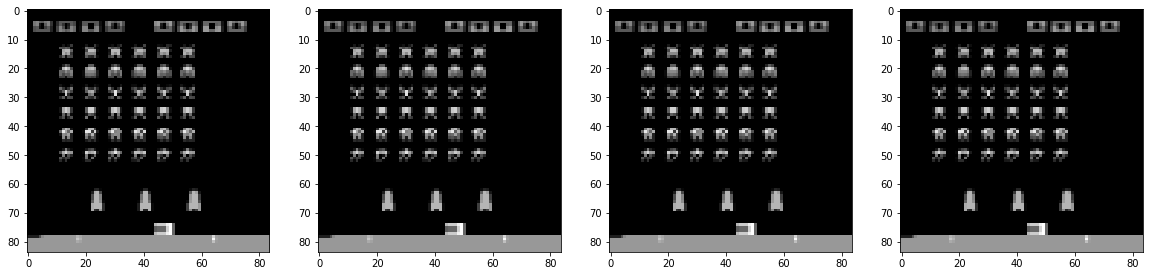

In [12]:
plt.figure(figsize=(20, 20))
i = 1
for i in range(states.shape[0]):
    plt.subplot(1, 4, i+1)
    plt.imshow(states[i,:,:], cmap='gray')

In [13]:
next_state, _, _, _ = env.step(1)
states, frames = stack_frames(frames, next_state, False)

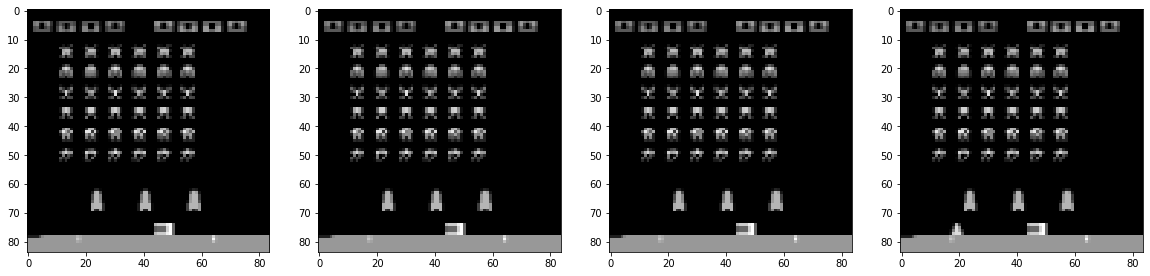

In [14]:
plt.figure(figsize=(20, 20))
i = 1
for i in range(states.shape[0]):
    plt.subplot(1, 4, i+1)
    plt.imshow(states[i], cmap='gray')

In [15]:
next_state, _, _, _ = env.step(1)
states, frames = stack_frames(frames, next_state, False)

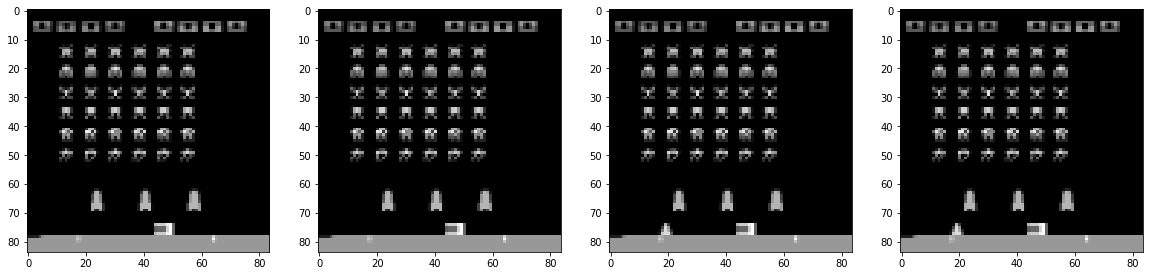

In [16]:
plt.figure(figsize=(20, 20))
i = 1
for i in range(states.shape[0]):
    plt.subplot(1, 4, i+1)
    plt.imshow(states[i], cmap='gray')

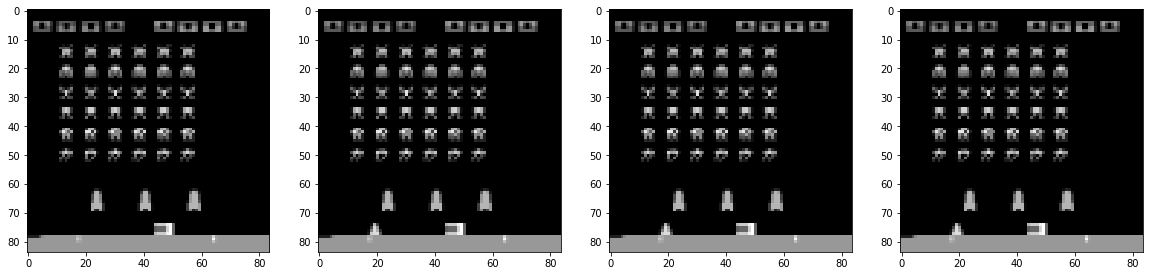

In [17]:
next_state, _, _, _ = env.step(1)
states, frames = stack_frames(frames, next_state, False)
plt.figure(figsize=(20, 20))
i = 1
for i in range(states.shape[0]):
    plt.subplot(1, 4, i+1)
    plt.imshow(states[i], cmap='gray')

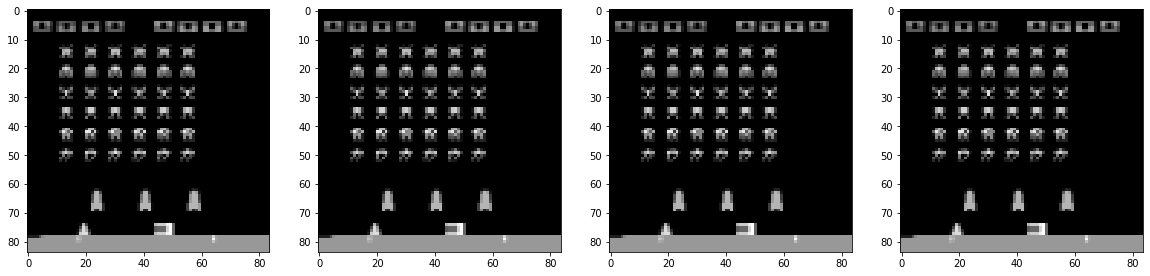

In [18]:
next_state, _, _, _ = env.step(1)
states, frames = stack_frames(frames, next_state, False)
plt.figure(figsize=(20, 20))
i = 1
for i in range(states.shape[0]):
    plt.subplot(1, 4, i+1)
    plt.imshow(states[i], cmap='gray')

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [20]:
class DQNetwork(nn.Module):
    def __init__(self, states, action_size, seed):
        super(DQNetwork, self).__init__()
        
        self.conv1 = nn.Conv2d(4, 32, (8, 8), stride=4)
        self.conv2 = nn.Conv2d(32, 64, (4, 4), stride=2)
        self.conv3 = nn.Conv2d(64, 128, (3, 3), stride=1)
        self.fc1 = nn.Linear(128*7*7, 512)
        self.fc2 = nn.Linear(512, action_size)
        
    def forward(self, state):
        x = F.relu(self.conv1(state))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(-1, 128*7*7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [24]:
import numpy as np
import random
from collections import namedtuple, deque
import torch
import torch.nn.functional as F
import torch.optim as optim

BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 4          # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = DQNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = DQNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences
        #next_states = next_states.permute(3,0,1,2).to(device)
        #states = states.permute(3,0,1,2).to(device)
        
        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states 
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
        
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)
        
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [25]:
def dqn(n_episodes=100, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start    
    # initialsize epsilon
    stack_size = 4 # We stack 4 frames
    stacked_frames  =  deque([np.zeros((84,84), dtype=np.int) for i in range(stack_size)], maxlen=4)
    for i_episode in range(1, n_episodes+1):
        
        state = env.reset()
        state, frames = stack_frames(stacked_frames, state, True)
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _  = env.step(action)
            next_state, frames = stack_frames(frames, next_state, False)
            agent.step(torch.from_numpy(state).float().unsqueeze(0).to(device), action, 
                         reward, torch.from_numpy(next_state).float().unsqueeze(0).to(device), done)
            #agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            #torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
    return scores

In [26]:
agent = Agent(state_size=4, action_size=env.action_space.n, seed=0)

In [27]:
dqn()

Episode 1	Average Score: 120.00

KeyboardInterrupt: 

In [158]:
agent = Agent(state_size=4, action_size=env.action_space.n, seed=0)
dqn(n_episodes=500)

Episode 100	Average Score: 184.05
Episode 138	Average Score: 194.35

KeyboardInterrupt: 

In [159]:
state = env.reset()
state, frames = stack_frames(stacked_frames, state, True)
score = 0
while True:
    action = agent.act(state, 1)
    next_state, reward, done, _ = env.step(action)
    next_state, frames = stack_frames(frames, next_state, False)
    score += reward
    state = next_state
    env.render()
    if done:
        print("Score", score)
        break

Score 290.0


In [160]:
torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')